In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch" # 'tensorflow', 'jax´ or 'torch'
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

In [4]:
df_raw = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
df = df_raw.asfreq('D').copy()
df = df.sort_index()

In [5]:
end_train = '2023-01-01'
end_validation = '2023-08-12'
df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2023-01-01 00:00:00  (n=1462)
Dates validacion : 2023-01-01 00:00:00 --- 2023-08-12 00:00:00  (n=224)
Dates test       : 2023-08-12 00:00:00 --- 2024-09-26 00:00:00  (n=412)


In [6]:

series = ['demanda', 'tmed', 'hrmed', 'festivo', 'diasem', 'trim']
levels = ['demanda']
lags = 7
steps = 1

data = df[series].copy()
data_train = df_train[series].copy()
data_val = df_val[series].copy()
data_test=df_test[series].copy()

def RNN(recurrent_units, dense_units, learning_rate, epochs, batch_size):
    # Crear el modelo RNN directamente dentro del forecaster
    model = create_and_compile_model(
        series=data_train,
        levels=levels, 
        lags=lags,
        steps=steps,
        recurrent_layer="LSTM",
        recurrent_units=recurrent_units,
        dense_units=dense_units,
        optimizer=Adam(learning_rate=learning_rate), 
        loss=MeanSquaredError()
    )

    # Crear el forecaster
    forecaster = ForecasterRnn(
        regressor=model,
        levels=levels,
        steps=steps,
        lags=lags,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,  # Ajusta según sea necesario
            "batch_size": batch_size,
            "series_val": data_val,
        },
    )

    # Fit forecaster
    # ==============================================================================
#    forecaster.fit(data_train)

    # Trainig and overfitting tracking
    # ==============================================================================
#    fig, ax = plt.subplots(figsize=(7, 3))
#    forecaster.plot_history(ax=ax)

    # Backtesting with test data
    # ==============================================================================
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        steps=forecaster.max_step,
        series=data,
        levels=forecaster.levels,
        initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
        metric="mean_absolute_error",
        verbose=False,
        refit=False,
    )
    return metrics, predictions

Testing combination: recurrent_units=100, dense_units=110, learning_rate=0.011, epochs=4, batch_size=12
keras version: 3.6.0
Using backend: torch
torch version: 2.5.0+cpu
Epoch 1/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0765 - val_loss: 0.0294
Epoch 2/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0195 - val_loss: 0.0249
Epoch 3/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0147 - val_loss: 0.0117
Epoch 4/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0077 - val_loss: 0.0095
Epoch 1/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 2/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0067 - val_loss: 0.0072
Epoch 3/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0056 - val_loss: 0.0104
Epoch 4/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0062 - val_loss: 0.0075


  0%|          | 0/411 [00:00<?, ?it/s]

c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.         0.16666667 0.33333333 0.5        0.66666667
 0.83333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: Futur

Testing combination: recurrent_units=100, dense_units=110, learning_rate=0.012, epochs=4, batch_size=12
keras version: 3.6.0
Using backend: torch
torch version: 2.5.0+cpu
Epoch 1/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0639 - val_loss: 0.0385
Epoch 2/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0190 - val_loss: 0.0262
Epoch 3/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0146 - val_loss: 0.0177
Epoch 4/4
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0146 - val_loss: 0.0136
Epoch 1/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0103 - val_loss: 0.0076
Epoch 2/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0054 - val_loss: 0.0076
Epoch 3/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0052 - val_loss: 0.0108
Epoch 4/4
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0058 - val_loss: 0.0078


  0%|          | 0/411 [00:00<?, ?it/s]

c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.         0.16666667 0.33333333 0.5        0.66666667
 0.83333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_window.loc[:, serie_name] = last_window_values
c:\Users\GregorioValverdeNava\anaconda3\Lib\site-packages\skforecast\ForecasterRnn\ForecasterRnn.py:730: Futur


Mejores hiperparámetros encontrados:
recurrent_units                                                  100
dense_units                                                      110
learning_rate                                                  0.012
epochs                                                             4
batch_size                                                        12
MAE                                                       923.034352
predictions                         demanda
2023-08-13  23880.775...
Name: 1, dtype: object


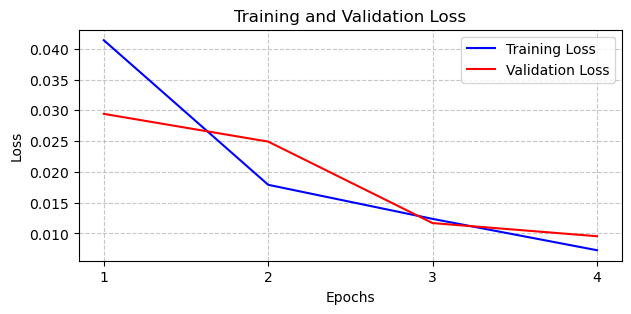

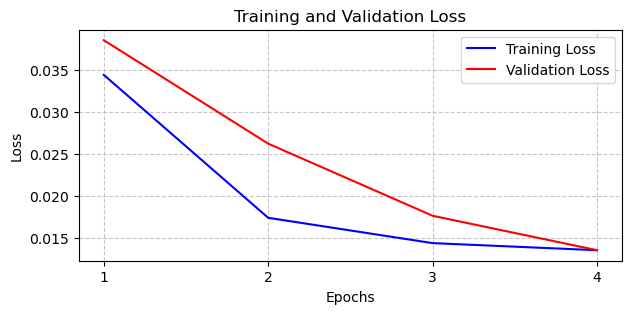

In [8]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'recurrent_units': [100],
    'dense_units': [110],
    'learning_rate': [ 0.011, 0.012],
    'epochs': [4],
    'batch_size': [12],
}

# Almacenar los resultados
results = []

# Realizar el grid search manual
for recurrent_units in param_grid['recurrent_units']:
    for dense_units in param_grid['dense_units']:
        for learning_rate in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    # Imprimir la combinación de hiperparámetros
                    print(f'Testing combination: recurrent_units={recurrent_units}, dense_units={dense_units}, '
                          f'learning_rate={learning_rate}, epochs={epochs}, batch_size={batch_size}')
                    
                    results_model = RNN(recurrent_units, dense_units, learning_rate, epochs, batch_size)

                    # Guardar los resultados y las predicciones
                    results.append({
                        'recurrent_units': recurrent_units,
                        'dense_units': dense_units,
                        'learning_rate': learning_rate,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'MAE': results_model[0]['mean_absolute_error'][0],  # Supongamos que 'metrics' contiene el MAE
                        'predictions': results_model[1]  # Guarda las predicciones
                    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Obtener el mejor resultado
best_result_index = results_df['MAE'].idxmin()  # Encuentra el índice del mejor MAE
mejor_result = results_df.loc[best_result_index]  # Obtiene el mejor resultado

# Imprimir el mejor resultado
print("\nMejores hiperparámetros encontrados:")
print(mejor_result)

# Guardar las predicciones del mejor resultado
best_predictions = mejor_result['predictions']


In [ ]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'recurrent_units': [100,110,120],
    'dense_units': [110],
    'learning_rate': [ 0.011, 0.012,0.013],
    'epochs': [4],
    'batch_size': [12, 14, 16,],
}

# Almacenar los resultados
results = []

# Realizar el grid search manual
for recurrent_units in param_grid['recurrent_units']:
    for dense_units in param_grid['dense_units']:
        for learning_rate in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    # Imprimir la combinación de hiperparámetros
                    print(f'Testing combination: recurrent_units={recurrent_units}, dense_units={dense_units}, '
                          f'learning_rate={learning_rate}, epochs={epochs}, batch_size={batch_size}')
                    
                    # Crear y compilar el modelo RNN
                    model = create_and_compile_model(
                        series=data_train,
                        levels=levels,
                        lags=lags,
                        steps=steps,
                        recurrent_layer="LSTM",
                        recurrent_units=recurrent_units,
                        dense_units=dense_units,
                        optimizer=Adam(learning_rate=learning_rate),
                        loss=MeanSquaredError()
                    )
                    
                    # Crear el forecaster
                    forecaster = ForecasterRnn(
                        regressor=model,
                        levels=levels,
                        steps=steps,
                        lags=lags,
                        transformer_series=MinMaxScaler(),
                        fit_kwargs={
                            "epochs": epochs,
                            "batch_size": batch_size,
                            "series_val": data_val,
                        },
                    )

                    # Ajustar el forecaster
                    forecaster.fit(data_train)

                    # Backtesting con los datos de prueba
                    metrics, predictions = backtesting_forecaster_multiseries(
                        forecaster=forecaster,
                        steps=forecaster.max_step,
                        series=data,
                        levels=forecaster.levels,
                        initial_train_size=len(data.loc[:end_validation, :]),
                        metric="mean_absolute_error",
                        verbose=False,
                        refit=False,
                    )

                    # Guardar los resultados y las predicciones
                    results.append({
                        'recurrent_units': recurrent_units,
                        'dense_units': dense_units,
                        'learning_rate': learning_rate,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'MAE': metrics['mean_absolute_error'][0],  # Supongamos que 'metrics' contiene el MAE
                        'predictions': predictions  # Guarda las predicciones
                    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Obtener el mejor resultado
best_result_index = results_df['MAE'].idxmin()  # Encuentra el índice del mejor MAE
mejor_result = results_df.loc[best_result_index]  # Obtiene el mejor resultado

# Imprimir el mejor resultado
print("\nMejores hiperparámetros encontrados:")
print(mejor_result)

# Guardar las predicciones del mejor resultado
best_predictions = mejor_result['predictions']


In [207]:
mejor_result

recurrent_units                                                  100
dense_units                                                      110
learning_rate                                                  0.011
epochs                                                             4
batch_size                                                        16
MAE                                                       735.626576
predictions                         demanda
2023-08-13  24513.669...
Name: 2, dtype: object

In [ ]:
predictions = best_predictions

plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='blue', linestyle='-') # Valores reales
plt.plot(predictions.index, predictions, label="Predictions", color='orange', linestyle='--') # Valores predichos


# Configurar el título y las etiquetas
plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Date Time")
plt.ylabel("Users")

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
